In [1]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import one_hot


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
train_data= pd.read_csv('../input/jigsaw-multilingual-toxic-comment-detection/jigsaw-toxic-comment-train.csv')
validation_data = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-detection/validation.csv')
test_data = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-detection/test.csv')

In [4]:
train_data.shape

(223549, 8)

In [5]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
validation_data.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [7]:
test_data.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [8]:
train_data.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [9]:
train_data.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [10]:
train_data["toxic"].value_counts()

0    202165
1     21384
Name: toxic, dtype: int64

In [11]:
train_data= train_data.loc[:15000,:]

In [12]:
train_data.shape

(15001, 3)

In [13]:
train_data["toxic"].value_counts()

0    13562
1     1439
Name: toxic, dtype: int64

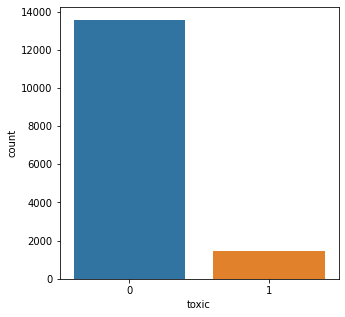

In [14]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x=train_data['toxic'],data=train_data)
plt.show()

In [15]:
test_mask=np.array(Image.open("../input/wodcloud-twiter-pic/twitter.png"))

In [16]:
# train_data["comment_text"].tolist()

In [17]:
wordcloud_text=" ".join(train_data["comment_text"].tolist())

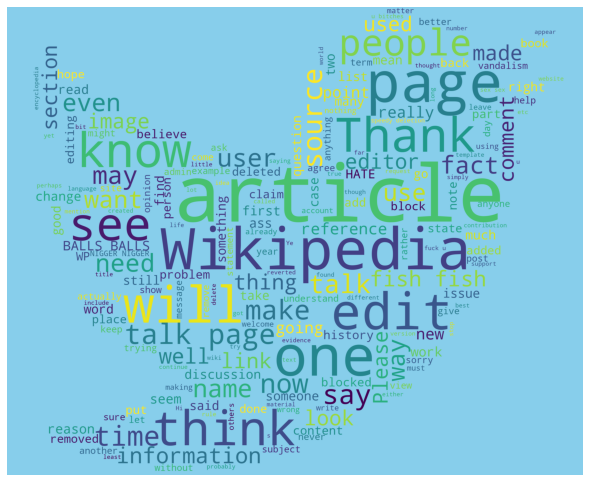

In [18]:
wordcloud=WordCloud(width=1920,height=1080,mask=test_mask,background_color ="skyblue").generate(wordcloud_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [19]:
train_data['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

In [20]:
train_data.sample(5)

,id,comment_text,toxic
10839,1ca778e37c633448,2009-Jan 2010]] [[User talk:GoodDay/Archive 1...,0
531,016340e730e14925,"Ok, I just ask. For your experience, what you ...",0
6391,1118928947b371fe,Essjay is identified as the individual wearing...,0
13480,239582ef5b2ca42b,"""\n\nThe above paragraph was written by a disc...",0
865,025d968155a0bb75,"OK, Steve, to be honest I really like the pres...",0


In [21]:
y=train_data["toxic"].values

In [22]:
train_data=train_data["comment_text"].copy()

In [23]:
corpus = []
for i in range(0, len(train_data)):
    review = train_data[i]
    review = review.split()
    review = ' '.join(review)
    corpus.append(review)

In [24]:
voc_size = 20000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [25]:
sent_length=300
embedded_docs=pad_sequences(onehot_repr,maxlen=sent_length,padding='pre')

In [26]:
print(embedded_docs)

[[    0     0     0 ... 19599 13444 13136]
 [    0     0     0 ...  4080 12162  8518]
 [    0     0     0 ... 12918 17008 11675]
 ...
 [    0     0     0 ... 19832 15979 15326]
 [    0     0     0 ... 14161 13768 15979]
 [    0     0     0 ... 16558 15505   921]]


In [27]:
X_final=np.array(embedded_docs)
Y_final=np.array(y)

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y_final, test_size=0.3, random_state=42,shuffle=True)

In [29]:
# X_train,X_test,Y_train,Y_test=train_test_split(X,Y,stratify=Y,random_state=42,test_size=0.2,shuffle=True)

In [30]:
# token = text.Tokenizer(num_words=None)
# max_len = 1500

# token.fit_on_texts(list(X_train) + list(X_test))
# Xtrain_seq = token.texts_to_sequences(X_train)
# Xtest_seq = token.texts_to_sequences(X_test)

# #zero pad the sequences
# Xtrain_pad = sequence.pad_sequences(Xtrain_seq, maxlen=max_len)
# Xtest_pad = sequence.pad_sequences(Xtest_seq, maxlen=max_len)

# word_index = token.word_index

In [31]:
features=40

model = Sequential()
model.add(Embedding(voc_size,features,input_length=sent_length))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2022-08-23 19:29:39.902947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 40)           800000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               14100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 814,201
Trainable params: 814,201
Non-trainable params: 0
_________________________________________________________________


2022-08-23 19:29:39.904508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 19:29:39.905258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 19:29:39.906559: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 19:29:39.906883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [32]:
# %%time
# with strategy.scope():
#     # A simpleRNN without any pretrained embeddings and one dense layer
#     model = Sequential()
#     model.add(Embedding(len(word_index) + 1,300,input_length=max_len))
                   
#     model.add(SimpleRNN(100))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
# model.summary()

In [33]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=5,batch_size=40)

Epoch 1/5


2022-08-23 19:29:41.252682: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


263/263 [==============================] - 81s 302ms/step - loss: 0.3573 - accuracy: 0.8768 - val_loss: 0.3261 - val_accuracy: 0.9007
Epoch 2/5
263/263 [==============================] - 78s 298ms/step - loss: 0.4242 - accuracy: 0.8505 - val_loss: 0.3457 - val_accuracy: 0.9060
Epoch 3/5
263/263 [==============================] - 85s 322ms/step - loss: 0.2966 - accuracy: 0.8969 - val_loss: 0.2909 - val_accuracy: 0.9116
Epoch 4/5
263/263 [==============================] - 76s 290ms/step - loss: 0.2089 - accuracy: 0.9218 - val_loss: 0.2875 - val_accuracy: 0.9125
Epoch 5/5
263/263 [==============================] - 77s 292ms/step - loss: 0.1732 - accuracy: 0.9425 - val_loss: 0.3022 - val_accuracy: 0.9049


In [34]:
# history=model.fit(Xtrain_pad, Y_train, epochs=5, batch_size=64 )

In [35]:
# def roc_auc(predictions,target):
    
#     fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
#     roc_auc = metrics.auc(fpr, tpr)
#     return roc_auc

In [36]:
# scores = model.predict(Xtest_pad)
# print("Auc: %.2f%%" % (roc_auc(scores,Y_test)))

In [37]:
y_pred=(model.predict(X_test) > 0.5).astype("int32")

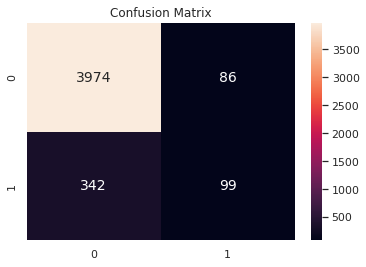

In [38]:
import seaborn as sn
cm = confusion_matrix(Y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={'size':14}, fmt='d').set_title('Confusion Matrix')
plt.show()

In [39]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4060
           1       0.54      0.22      0.32       441

    accuracy                           0.90      4501
   macro avg       0.73      0.60      0.63      4501
weighted avg       0.88      0.90      0.89      4501



Custom Data Prediction

In [40]:
x=["the most illiterate ,ill manared,psychopath just barks whatever shit out of his mouth"]

In [41]:
Y= []
for i in range(0, len(x)):
    review =x[i]
    review = review.split()
    review = ' '.join(review)
    Y.append(review)

In [42]:
voc_size = 2000
onehot_repr=[one_hot(words,voc_size)for words in Y] 

In [43]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,maxlen=sent_length,padding='pre')

In [44]:
Y=np.array(embedded_docs)

In [45]:
prediction=(model.predict(Y)>0.5).astype(int)

1=toxic comment///////
0=non toxic comment

In [47]:
if prediction==1:
    print("toxic")
else:
    print("non toxic")

toxic
